# Andy Yang

# Q1: Setting Up the Environment

Used https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/ repo to start. I added walls ("forbidden transitions") and one hot encoding of states.

Note to Professor/Grader: The way I had things structured, I had this next cell in a .py file in a folder in my working directory, so I assume just downloading this ipynb and running it run into some errors.

In [ ]:
import gym
from gym import spaces
import pygame
import numpy as np


class GridWorldEnv(gym.Env):
    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

    def __init__(self, render_mode=None, size=5):
        self.size = size  # The size of the square grid
        self.window_size = 512  # The size of the PyGame window
        
        # WALLS
        self.forbidden_transitions = {((0, 0), (1, 0)), ((1, 0), (0, 0)), ((0, 1),(1, 1)),((1, 1), (0, 1)),((0, 2), (1, 2)),((1, 2), (0, 2))}

        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).


        
        self.observation_space = spaces.Dict(
            {
                "agent": spaces.Box(low=0, high=1, shape=(16,), dtype=np.int64),
                "target": spaces.Box(0, size - 1, shape=(2,), dtype=int),
            }
        )

        # We have 4 actions, corresponding to "right", "up", "left", "down", "right"
        self.action_space = spaces.Discrete(4)

        """
        The following dictionary maps abstract actions from `self.action_space` to 
        the direction we will walk in if that action is taken.
        I.e. 0 corresponds to "right", 1 to "up" etc.
        """
        self._action_to_direction = {
            0: np.array([1, 0]),
            1: np.array([0, 1]),
            2: np.array([-1, 0]),
            3: np.array([0, -1]),
        }

        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

    def _get_obs(self):
        return {"agent": self.encode_agent_position(self._agent_location), "target": self._target_location}

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }
    def position_to_index(self, position, grid_width=4):
        row, column = position
        return row * grid_width + column
    
    def one_hot_encode(self, index, vector_length=16):
        vector = np.zeros(vector_length, dtype=np.int64)
        vector[index] = 1
        return vector
    
    def encode_agent_position(self, position):
        index = self.position_to_index(position)
        one_hot_vector = self.one_hot_encode(index)
        return one_hot_vector

    def reset(self, seed=None, options=None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        # self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)
        self._agent_location = np.array([3, 0], dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        # self._target_location = self._agent_location
        # while np.array_equal(self._target_location, self._agent_location):
        #     self._target_location = self.np_random.integers(
        #         0, self.size, size=2, dtype=int
        #     )
        self._target_location = np.array([0, 0], dtype=int)


        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        # Map the action (element of {0,1,2,3}) to the direction we walk in
        direction = self._action_to_direction[action]

        # This is the logic for preventing moves over the wall
        # Essentially, we propose a transition pair (start, destination) is in self.forbidden_moves then we set the agent location to itself
        proposed_location = self._agent_location + direction
        attempted_transition = (tuple(self._agent_location), tuple(proposed_location))
        if attempted_transition not in self.forbidden_transitions:
            # We use `np.clip` to make sure we don't leave the grid
            self._agent_location = np.clip(
                self._agent_location + direction, 0, self.size - 1
            )
        else:
            # print("Hit the wall, agent location unchanged.")
            self._agent_location = self._agent_location
        
        # An episode is done iff the agent has reached the target
        terminated = np.array_equal(self._agent_location, self._target_location)
        reward = 10 if terminated else 0  # REWARD
        observation = self._get_obs()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, reward, terminated, False, info

    def render(self):
        if self.render_mode == "rgb_array":
            return self._render_frame()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.size
        )  # The size of a single grid square in pixels

        # First we draw the target
        pygame.draw.rect(
            canvas,
            (255, 0, 0),
            pygame.Rect(
                pix_square_size * self._target_location,
                (pix_square_size, pix_square_size),
            ),
        )
        # Now we draw the agent
        pygame.draw.circle(
            canvas,
            (0, 0, 255),
            (self._agent_location + 0.5) * pix_square_size,
            pix_square_size / 3,
        )

        # Finally, add some gridlines
        for x in range(self.size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )

    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()
    def get_agent_location(self):
        return self._agent_location

    def get_target_location(self):
        return self._target_location



## Testing the env. Random movements on grid to prove it works.

Notice how there are never any transitions from 
- [1, 0] to [0, 0] or vice versa
- [1, 1] to [0, 1] or vice versa
- [1, 2] to [0, 2] or vice versa

In [5]:
import gym
import gym_examples
import numpy as np

env = gym.make('gym_examples/GridWorld-v0', size=4)

state = env.reset()
agent_location = env.get_agent_location()
target_location = env.get_target_location()
print(f"Agent's INITIAL Location: {agent_location}, Target Location: {target_location}")

done = False


while not done:
    # Select action randomly
    action = env.action_space.sample()
    
    # take step, returns transition
    next_state, reward, done, truncated, info = env.step(action)
    
    agent_location = env.get_agent_location()
    target_location = env.get_target_location()
    print(f"Agent's Location: {agent_location}, Target Location: {target_location}")

    #update state
    state = next_state

env.close()

print("Episode finished")


Agent's INITIAL Location: [3 0], Target Location: [0 0]
Agent's Location: [2 0], Target Location: [0 0]
Agent's Location: [2 1], Target Location: [0 0]
Agent's Location: [3 1], Target Location: [0 0]
Agent's Location: [2 1], Target Location: [0 0]
Agent's Location: [2 0], Target Location: [0 0]
Agent's Location: [2 1], Target Location: [0 0]
Agent's Location: [3 1], Target Location: [0 0]
Agent's Location: [2 1], Target Location: [0 0]
Agent's Location: [3 1], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 3], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [2 2], Target Location: [0 0]
Agent's Location: [2 1], Target Location: [0 0]
Agent's Location: [2 2], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 1], Target Location: [0 0]
Agent's Location: [3 2], Target Location: [0 0]
Agent's Location: [3 2], Target 

/Users/andyyang/Desktop/DS598 Reinforcement Learning/gym-examples/.env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


# Q2a: Deep Q Network

Here is the architecture of the network and Agent class. I made some notes just for myself, please ignore those.

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = F.mse_loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        actions = self.fc2(x)  # Directly output action values from the first layer's output

        return actions

    

class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=10000, eps_end=0.01, eps_dec = 5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=128, fc2_dims=128)

        # something for storing memory deq
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32) #remmeber, temperal diff wants state, next state, reward, action 
        # DeepQLearning is a model free, bootstrapped, off policy learning method
        # dont need to know anything about dynamics of environment, we'll figure it out by playing the game (modelfree)
        # bootstrapped =   going to construct estimates of Q function, based on earlier estimates. using one estimate to update the next
        # offpolicy = policy used to generate actions is epsilon greedy. 
                    # epsilon determines portion of time used to take random vs greedy actions. use this policy to generate data to update the purely greedy policy
                    # ^ the agents estimate of the maximum value functoin
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)

        self.terminal_memory = np.zeros(self.mem_size, dtype=bool) # if you encounter terminal state, game is done

    def store_transitions(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # posiiton of first unoccupied memory
        # print(f"index: {index}")
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon: #take the best known action
            state = T.tensor(observation, dtype=T.float32).to(self.Q_eval.device) #take our current state (observation), turn into tensor, send to device
            # print(f"state: {state}")
            actions = self.Q_eval.forward(state) #remember, this gives out 4 outputs, take the index of biggest one
            # print(f"four actions: {actions}")
            action = T.argmax(actions).item()
            # print(f"selected action: {action}")
        else:
            action = np.random.choice(self.action_space)
            # print(f"randomly selected action: {action}")
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size: #if memory is filled up with zeros (just np.zeros like initialized), we start learning as soon as we fill up batch size of memory
            return
        
        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False) #grab a batch of memories

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device) # convert the numpy array subset of memory into agent's tensor
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch] 

        # now need to perform feedforward to get the parameters for loss function
        # we want to be moving the agent's estimate for the value of the current state towards the maximal value of the next state. or
        # tilt it towrads selecting maximal actions

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        # print(f"Q_EVAL: {q_eval}")
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        # calculate the target values
        q_target = reward_batch + self.gamma *  T.max(q_next, dim=1)[0] #this is the purely greedy action
        # print(f"Q_TARGET: {q_target}")

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        # print(f"LOSS: {loss}")
        loss.backward()
        self.Q_eval.optimizer.step()

        # handle epsilon decrement
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

This is the training loop and graphing

In [1]:
import gym
import gym_examples
from dqn import Agent
import numpy as np

n_runs = 10  # Number of complete training runs
n_episodes = 100  # Number of episodes per training run

all_runs_steps = []

for run in range(n_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)
    agent = Agent(gamma=0.9, epsilon=0.5, batch_size=10, n_actions=4, eps_end=0.01, input_dims=[16], lr=0.003)
    scores, eps_hist, avg_scores_dqn = [], [], []
    steps_per_episode = []  # Track number of steps for each episode, IN THIS RUN

    for i in range(n_episodes):
        score = 0
        done = False
        observation = env.reset()[0]['agent']
        steps = 0

        while not done:
            # choose an action based on current state of env
            action = agent.choose_action(observation)
            

            observation_, reward, done, truncated, info = env.step(action)
            observation_ = observation_['agent']  # since one hot encoded state is nested in dictionary

            score += reward
        
            # store transition and update weights
            agent.store_transitions(observation, action, reward, observation_, done)
            agent.learn()

            # update state
            observation = observation_

            # end of an episode
            steps += 1

        steps_per_episode.append(steps)
    
    all_runs_steps.append(steps_per_episode)
    print(f'Run {run + 1} completed')

# Convert to NumPy array to aggregate index-wise
all_runs_steps_np = np.array(all_runs_steps)

avg_steps_per_episode = np.mean(all_runs_steps_np, axis=0)

# Now avg_steps_per_episode is an array with the averaged steps for each episode across all runs
print("Average steps per episode over all runs:", avg_steps_per_episode)


/Users/andyyang/Desktop/DS598 Reinforcement Learning/gym-examples/.env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 1 completed
Run 2 completed
Run 3 completed
Run 4 completed
Run 5 completed
Run 6 completed
Run 7 completed
Run 8 completed
Run 9 completed
Run 10 completed
Average steps per episode over all runs: [246.1 240.8 107.3  78.3  41.9  70.6  33.8  27.9  17.9  14.   10.1  10.8
  10.9   9.5  10.4   9.6   9.5   9.3   9.8   9.3   9.    9.2   9.3   9.2
   9.1   9.4   9.5   9.    9.4   9.8   9.3   9.5   9.3   9.4   9.1   9.4
   9.1   9.3   9.2   9.    9.    9.    9.    9.    9.    9.2   9.2   9.1
   9.1   9.    9.    9.    9.2   9.1   9.1   9.    9.    9.    9.2   9.2
   9.    9.1   9.    9.    9.    9.    9.    9.3   9.5   9.3   9.3   9.
   9.    9.    9.    9.    9.    9.    9.5   9.    9.    9.1   9.    9.
   9.2   9.1   9.    9.    9.2   9.2   9.    9.    9.    9.    9.    9.
   9.    9.    9.1   9.2]


To plot the learning curve averaging over 10 runs, I trained for 100 episodes, ten times and took the average duration for each episode over the ten runs. As we can see in the plot, the DQN on average takes around ten episodes of training before it begins to consistently act optimally.

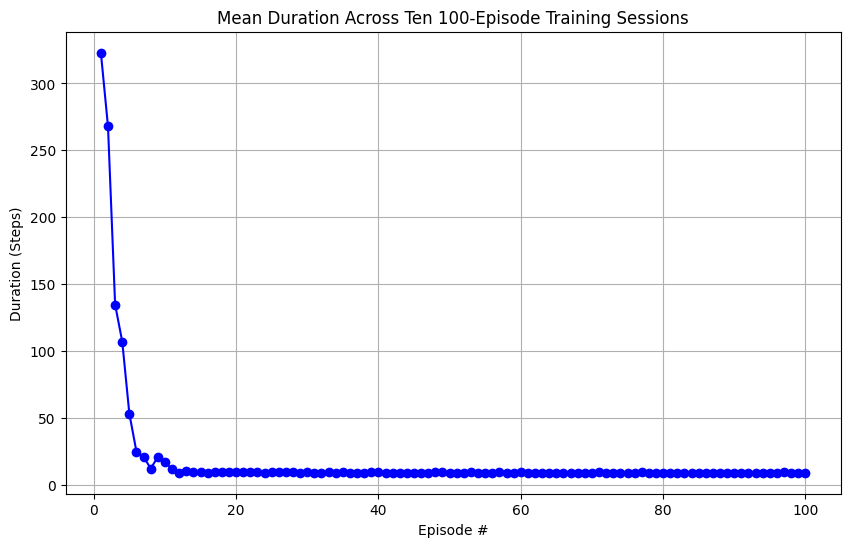

In [7]:
# plot the average score per episode
import matplotlib.pyplot as plt

episodes = list(range(1, n_episodes + 1))

plt.figure(figsize=(10, 6))
plt.plot(episodes, avg_steps_per_episode, marker='o', linestyle='-', color='b')
plt.title('Mean Duration Across Ten 100-Episode Training Sessions')
plt.xlabel('Episode #')
plt.ylabel('Average Duration (Steps)')
plt.grid(True)
plt.show()


# Q2b: Double DQN

Here is the Double DQN architecture. The only difference here is that we use q_next_target, the target network, to evaluate action, and we added an update_freq param

In [ ]:
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = F.mse_loss
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions
    
class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, update_freq, max_mem_size=10000, eps_end=0.01, eps_dec = 5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.update_freq = update_freq
        
        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=128, fc2_dims=128)
        self.Q_target = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=128, fc2_dims=128)


        # something for storing memory deq
        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32) #remmeber, temperal diff wants state, next state, reward, action 
        # DeepQLearning is a model free, bootstrapped, off policy learning method
        # dont need to know anything about dynamics of environment, we'll figure it out by playing the game (modelfree)
        # bootstrapped =   going to construct estimates of Q function, based on earlier estimates. using one estimate to update the next
        # offpolicy = policy used to generate actions is epsilon greedy. 
                    # epsilon determines portion of time used to take random vs greedy actions. use this policy to generate data to update the purely greedy policy
                    # ^ the agents estimate of the maximum value functoin
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)

        self.terminal_memory = np.zeros(self.mem_size, dtype=bool) # if you encounter terminal state, game is done

    def store_transitions(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size # posiiton of first unoccupied memory
        # print(f"index: {index}")
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def choose_action(self, observation):
        if np.random.random() > self.epsilon: #take the best known action
            state = T.tensor(observation, dtype=T.float32).to(self.Q_eval.device) #take our current state (observation), turn into tensor, send to device
            # print(f"state: {state}")
            actions = self.Q_eval.forward(state) #remember, this gives out 4 outputs, take the index of biggest one
            # print(f"four actions: {actions}")
            action = T.argmax(actions).item()
            # print(f"selected action: {action}")
        else:
            action = np.random.choice(self.action_space)
            # print(f"randomly selected action: {action}")
        return action
    
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        
        self.Q_eval.optimizer.zero_grad()
        
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)
        
        batch_index = np.arange(self.batch_size, dtype=np.int32)
        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        
        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next_eval = self.Q_eval.forward(new_state_batch)  # Use the policy network to select action
        q_next_target = self.Q_target.forward(new_state_batch)  # Use the target network to evaluate action
        
        max_actions = T.argmax(q_next_eval, dim=1)
        q_next = q_next_target[batch_index, max_actions]
        
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * q_next
        
        loss = self.Q_eval.loss(q_target, q_eval)
        loss.backward()
        self.Q_eval.optimizer.step()
        
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        
        # Optionally, update the target network here by hard copying or soft updating the weights
        if self.mem_cntr % self.update_freq == 0:
            self.Q_target.load_state_dict(self.Q_eval.state_dict())

And the training loop. We update the target network every 50 iters

In [8]:
import gym
import gym_examples
from doubledqn import Agent 
import numpy as np

n_runs = 10  # Number of complete training runs
n_episodes = 100  # Number of episodes per training run

all_runs_steps_ddqn = []

for run in range(n_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)
    agent = Agent(gamma=0.9, epsilon=0.5, batch_size=10, n_actions=4, eps_end=0.01, input_dims=[16], lr=0.003, update_freq=50)
    steps_per_episode = []  # Track steps for each episode in this run

    for i in range(n_episodes):
        done = False
        observation = env.reset()[0]['agent']
        steps = 0

        while not done:
            # choose an action based on current state of env
            action = agent.choose_action(observation)

            observation_, reward, done, truncated, info = env.step(action)
            observation_ = observation_['agent']  # since one hot encoded state is nested in dictionary

            # store transition and update weights
            agent.store_transitions(observation, action, reward, observation_, done)
            agent.learn()

            # update state
            observation = observation_

            # end of an episode
            steps += 1

        steps_per_episode.append(steps)
    
    all_runs_steps_ddqn.append(steps_per_episode)
    print(f'Double DQN Run {run + 1} completed')

# convert to numpy for aggregation
all_runs_steps_ddqn_np = np.array(all_runs_steps_ddqn)

avg_steps_per_episode_ddqn = np.mean(all_runs_steps_ddqn_np, axis=0)

print("Average steps per episode over all DDQN runs:", avg_steps_per_episode_ddqn)


Double DQN Run 1 completed
Double DQN Run 2 completed
Double DQN Run 3 completed
Double DQN Run 4 completed
Double DQN Run 5 completed
Double DQN Run 6 completed
Double DQN Run 7 completed
Double DQN Run 8 completed
Double DQN Run 9 completed
Double DQN Run 10 completed
Average steps per episode over all DDQN runs: [156.1 164.4  97.3  49.5  27.5  26.7  19.9  19.   19.7  13.6  13.6  13.6
  11.6  12.3  10.3  10.5  12.9  10.8  10.9  10.2  11.5  10.1  10.4  10.5
  10.2  11.1  10.7   9.8  10.8   9.7  10.    9.4   9.6   9.7   9.8   9.3
   9.8   9.5   9.6   9.1   9.3   9.6   9.4   9.3   9.    9.1   9.5   9.3
   9.    9.1   9.2   9.4   9.    9.    9.2   9.1   9.    9.    9.2   9.
   9.3   9.3   9.2   9.    9.2   9.    9.    9.2   9.    9.2   9.    9.
   9.3   9.1   9.    9.    9.    9.2   9.2   9.    9.    9.    9.    9.
   9.1   9.    9.3   9.    9.1   9.1   9.    9.    9.    9.    9.1   9.
   9.    9.3   9.1   9.1]


Here, we can plot the same thing as the DQN. Similar to the DQN, the double DQN on average (over ten runs), takes around ten episodes to consistenly reach the reward in the optimal number of actions. However, in those episodes, it sometimes performs better than the DQN. For example, in the first episode, the regular DQN on average took 323.0 steps, where the double DQN took 156.1.

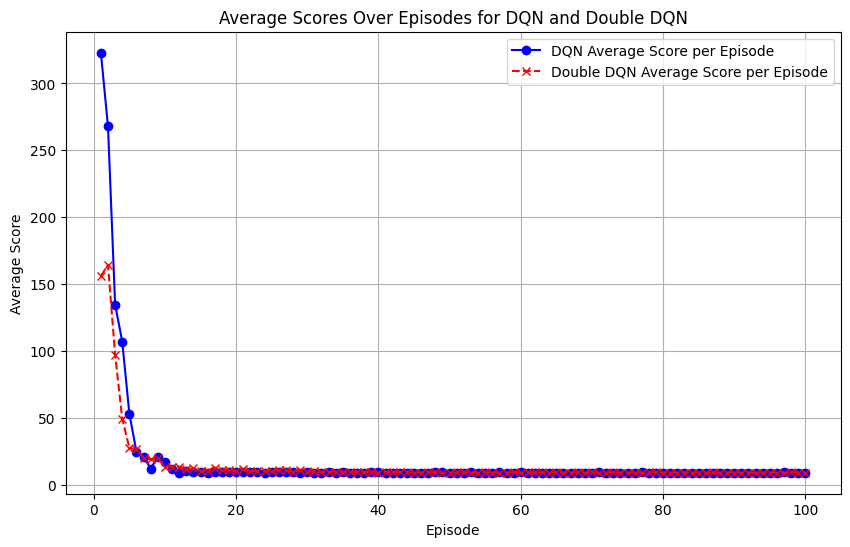

In [9]:
import matplotlib.pyplot as plt

episodes = list(range(1, 100 + 1))

plt.figure(figsize=(10, 6))

# Plot for regular DQN
plt.plot(episodes, avg_steps_per_episode, marker='o', linestyle='-', color='b', label='DQN Average Score per Episode')

# Plot for Double DQN
plt.plot(episodes, avg_steps_per_episode_ddqn, marker='x', linestyle='--', color='r', label='Double DQN Average Score per Episode')

plt.title('Mean Duration Across Ten 100-Episode Training Sessions')
plt.xlabel('Episode #')
plt.ylabel('Average Duration (Steps)')
plt.legend()
plt.grid(True)
plt.show()


# Q3a: REINFORCE Algorithm

In [1]:
import gym
import gym_examples
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

env = gym.make('gym_examples/GridWorld-v0', size=4)

In [2]:
state_size = 16
action_size = 4

In [3]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.softmax(x, dim=-1)

policy = Policy()

In [4]:
def update_policy(rewards, log_probs, optimizer):
    R = 0
    policy_loss = []
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalize returns
    for log_prob, R in zip(log_probs, returns):
        policy_loss.append(-log_prob * R)
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()


gamma = 0.9


/Users/andyyang/Desktop/DS598 Reinforcement Learning/gym-examples/.env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 1/10 completed.
Run 2/10 completed.
Run 3/10 completed.
Run 4/10 completed.
Run 5/10 completed.
Run 6/10 completed.
Run 7/10 completed.
Run 8/10 completed.
Run 9/10 completed.
Run 10/10 completed.


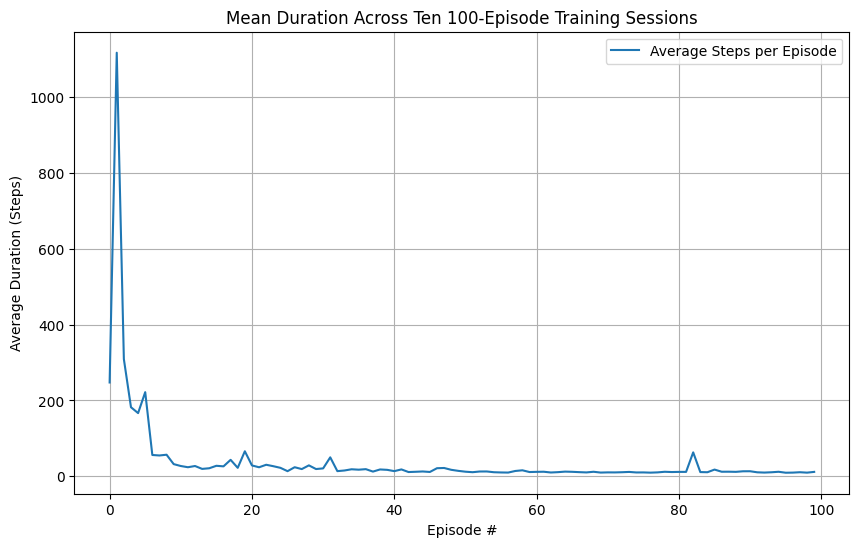

In [8]:
num_runs = 10
num_episodes = 100

# Initialize an array to store the number of steps for all runs
steps_per_episode = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)    
    policy = Policy()  # Reinitialize your policy
    optimizer = optim.Adam(policy.parameters(), lr=0.03)

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False

        log_probs = []
        rewards = []
        steps = 0  # Initialize step counter for this episode

        while not done:
            state = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']

            rewards.append(reward)
            log_probs.append(log_prob)
            state = next_state
            steps += 1  # Increment step count

        steps_per_episode[run, episode] = steps  # Store the number of steps for this episode
        update_policy(rewards, log_probs, optimizer)  # Update the policy

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average number of steps across all runs for each episode
average_steps = np.mean(steps_per_episode, axis=0)

# Plotting the learning curve for steps
plt.figure(figsize=(10, 6))
plt.plot(average_steps, label='Average Steps per Episode')
plt.title("Mean Duration Across Ten 100-Episode Training Sessions")
plt.xlabel("Episode #")
plt.ylabel("Average Duration (Steps)")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
np.mean(average_steps[:25])

92.13600000000001

In [24]:
np.mean(average_steps[75:])

11.607999999999999

As we can see, after training for 100 episodes ten times and averaging the duration of each episode, we can see that it takes around 10-15 episodes before consistently reaching the reward in very few steps. The average number of steps it took in the final 25 episodes is 11.6 which is a lot beter than the first twenty five episodes (avg of92.1 steps).

# Q3b. Using Vstar as Baseline

To do this, we need to manually calculate the Vstar values.

In [10]:
V_star = [10*gamma, 10, 10*gamma, 10*gamma**2,
 10*gamma**6, 10*gamma**5, 10*gamma**4, 10*gamma**3,
 10*gamma**7, 10*gamma**6, 10*gamma**5, 10*gamma**4,
 10*gamma**8, 10*gamma**7, 10*gamma**6, 10*gamma**5]

Then we just need to change how we update our policy so that we subtract the respective Vstar value from the return before multiplying by the log probs

In [11]:
def update_policy(policy, rewards, log_probs, states, V_star, optimizer_policy):
    R = 0
    policy_loss = []
    returns = []
    # print(f"STATES: {states}")
    # print(f"REWARDS: {rewards}")
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    
    for log_prob, R, state in zip(log_probs, returns, states):
        # Subtract the baseline (V*) from the return
        baseline = V_star[state] # Baseline!
        advantage = R - baseline
        policy_loss.append(-log_prob * advantage)
    
    optimizer_policy.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer_policy.step()


Now we can train our network as usual, except making sure to collect states too so that we can look up their Vstar values in `update_policy()`

reached the treasure in 29 steps. This is episode 0, updating policy now
reached the treasure in 74 steps. This is episode 1, updating policy now
reached the treasure in 905 steps. This is episode 2, updating policy now
reached the treasure in 496 steps. This is episode 3, updating policy now
reached the treasure in 256 steps. This is episode 4, updating policy now
reached the treasure in 202 steps. This is episode 5, updating policy now
reached the treasure in 55 steps. This is episode 6, updating policy now
reached the treasure in 146 steps. This is episode 7, updating policy now
reached the treasure in 100 steps. This is episode 8, updating policy now
reached the treasure in 248 steps. This is episode 9, updating policy now
reached the treasure in 309 steps. This is episode 10, updating policy now
reached the treasure in 167 steps. This is episode 11, updating policy now
reached the treasure in 354 steps. This is episode 12, updating policy now
reached the treasure in 31 steps. This

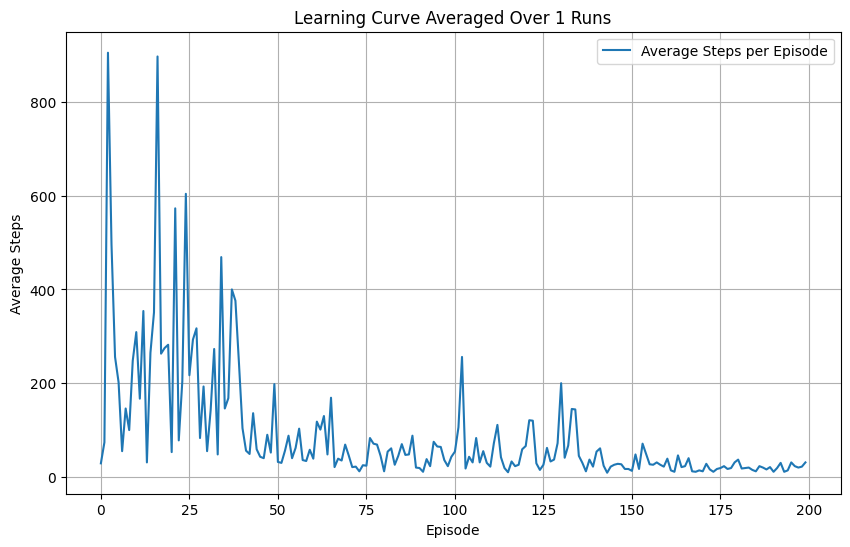

In [14]:
num_runs = 1
num_episodes = 200

# Initialize an array to store the number of steps for all runs
steps_per_episode = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)    
    policy = Policy()  # Reinitialize your policy
    optimizer_policy = optim.Adam(policy.parameters(), lr=0.005)

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False

        log_probs = []
        rewards = []
        states = []
        steps = 0  # Initialize step counter for this episode

        while not done:
            # print(f"state: {np.argmax(state)}")
            state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state_tensor)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(np.argmax(state))  # Convert state to its index
            state = next_state
            steps += 1
            # print("---")

        steps_per_episode[run, episode] = steps
        print(f"reached the treasure in {steps} steps. This is episode {episode}, updating policy now")
        update_policy(policy, rewards, log_probs, states, V_star, optimizer_policy)

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average number of steps across all runs for each episode
average_steps = np.mean(steps_per_episode, axis=0)

# Plotting the learning curve for steps
plt.figure(figsize=(10, 6))
plt.plot(average_steps, label='Average Steps per Episode')
plt.title("Learning Curve Averaged Over 1 Runs")
plt.xlabel("Episode")
plt.ylabel("Average Steps")
plt.legend()
plt.grid(True)
plt.show()


I'm not too sure why my variance is higher here because I feel like my implementation is correct:

After an episode finishes, it updates its weights by first calculating the discounted expected value of a state by 

```
for r in rewards[::-1]:
    R = r + gamma * R
    returns.insert(0, R)
``` 
        
Then we subracting the respective V_star value from these values and multiply that by the negative log prob to get our loss. In theory, this should lower the variance because we effectively reduce the range of the values that go into the gradient calculation, making the updates more stable. For example, if the return is above the baseline, it says that the action taken was better than average for that state, encouraging the policy to favor that action in the future and if the return is below the baseline, it suggests the action was worse than average, discouraging that action.

Also I only ran it once, because the question did not ask for average results.

I was not able to debug this, so I will just continue with part c.

# Q3c: Plotting Variance

In order to calculate the empirical variance of a policy gradient, we need a way to find the policy gradient itself. We can do this with the `compute_gradients` function where for a given trajectory we sum the gradients of the log policy weighted by its return, minus the baseline.

In [22]:
def compute_gradients(policy, rewards, log_probs, states, V_star=None, gamma=0.9):
    R = 0
    policy_gradients = []
    returns = []
    for r in rewards[::-1]:
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32)
    
    for log_prob, R, state in zip(log_probs, returns, states):
        idx = state
        baseline = V_star[idx] if V_star is not None else 0 # calculating for both with and without
        advantage = R - baseline
        policy_gradients.append(-log_prob * advantage)
    
    return torch.stack(policy_gradients).sum(dim=0)

def empirical_variance(gradients):
    mean_gradient = torch.mean(torch.stack(gradients), dim=0)
    variance = torch.mean((torch.stack(gradients) - mean_gradient)**2)
    return variance.item()

/Users/andyyang/Desktop/DS598 Reinforcement Learning/gym-examples/.env/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Run 1/1 completed.


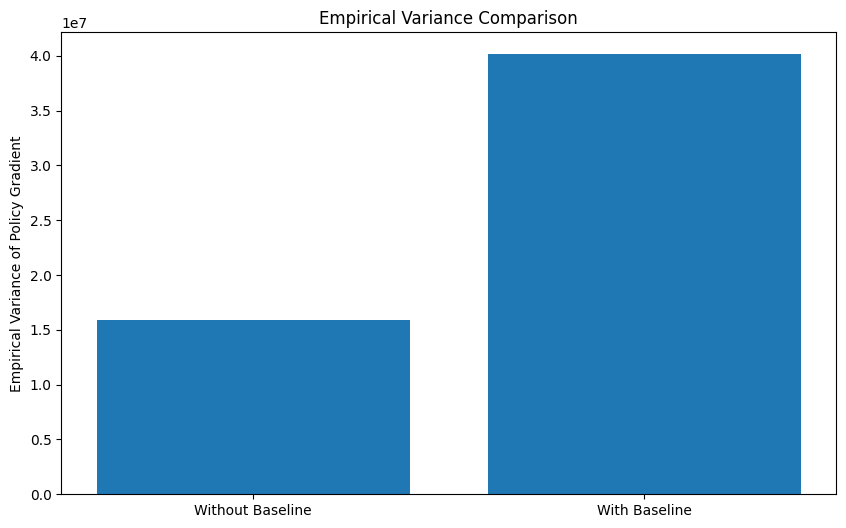

In [23]:
num_runs = 1
num_episodes = 100
gamma = 0.9

# Arrays to store variances
variance_with_baseline = []
variance_without_baseline = []

for run in range(num_runs):
    env = gym.make('gym_examples/GridWorld-v0', size=4)
    policy = Policy()
    optimizer_policy = optim.Adam(policy.parameters(), lr=0.005)

    gradients_with_baseline = []
    gradients_without_baseline = []

    for episode in range(num_episodes):
        state = env.reset()[0]['agent']
        done = False

        log_probs = []
        rewards = []
        states = []


        while not done:
            state_tensor = torch.tensor(state, dtype=torch.float32).reshape(1, -1)
            probs = policy(state_tensor)
            action = torch.multinomial(probs, 1).item()
            log_prob = torch.log(probs[:, action])

            next_state, reward, done, _, _ = env.step(action)
            next_state = next_state['agent']

            rewards.append(reward)
            log_probs.append(log_prob)
            states.append(np.argmax(state))  # Convert state to its index
            state = next_state
            steps += 1

        steps_per_episode[run, episode] = steps

        # Compute gradients
        gradients_with_baseline.append(compute_gradients(policy, rewards, log_probs, states, V_star))
        gradients_without_baseline.append(compute_gradients(policy, rewards, log_probs, states))

    # Compute empirical variance
    variance_with_baseline.append(empirical_variance(gradients_with_baseline))
    variance_without_baseline.append(empirical_variance(gradients_without_baseline))

    # Use the mean of gradients to update the policy after all episodes
    optimizer_policy.zero_grad()
    mean_gradient_with_baseline = torch.mean(torch.stack(gradients_with_baseline), dim=0)
    mean_gradient_with_baseline.backward()
    optimizer_policy.step()

    print(f"Run {run+1}/{num_runs} completed.")

# Calculate the average number of steps across all runs for each episode
average_steps = np.mean(steps_per_episode, axis=0)

# Calculate the average empirical variances across runs
average_variance_with_baseline = np.mean(variance_with_baseline)
average_variance_without_baseline = np.mean(variance_without_baseline)

# Plotting the empirical variances
plt.figure(figsize=(10, 6))
plt.bar(['Without Baseline', 'With Baseline'], [average_variance_without_baseline, average_variance_with_baseline])
plt.ylabel('Empirical Variance of Policy Gradient')
plt.title("Empirical Variance Comparison")
plt.show()


As we can see, the variance for the policy gradient with baseline is larger than without, which is what we saw in parts a and b as well. Here are the numbers:

In [25]:
average_variance_with_baseline, average_variance_without_baseline

(15407830.0, 5869120.0)